recapture CellOrbitCorrection.py

In [23]:
import sys

sys.path.append("../")

import copy

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import scipy.optimize

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', "svg")
import matplotlib.colors
import matplotlib.pyplot as plt


from OcelotMinimal.cpbd import elements

from IPython.display import display

In [24]:
from TorchOcelot.Lattice import SIS18_Lattice, SIS18_Cell  # correctors are defined as Hcor
from TorchOcelot.Models import SecondOrderModel

In [25]:
import PlotTrajectory

general properties

In [26]:
dtype = torch.float32
device = torch.device("cpu")

create model

In [27]:
dim = 2
Lattice = SIS18_Cell

lattice = Lattice()
model = SecondOrderModel(lattice, dim, dtype).to(device)
model.requires_grad_(False)

oldModel = copy.deepcopy(model)

for m in model.maps:
    # add trainable bias to map
    bias = torch.zeros(dim, dtype=dtype)
    m.w1.bias = nn.Parameter(bias, requires_grad=True)


create accelerator

In [28]:
perturbedLattice = Lattice()

for element in perturbedLattice.sequence:
    if type(element) is elements.Quadrupole:
        element.dx = torch.normal(mean=0., std=5e-4, size=(1,)).item()  # same sigma as in TM-PNN

perturbedLattice.update_transfer_maps()

perturbedModel = SecondOrderModel(perturbedLattice, dim, dtype).to(device)
for m in perturbedModel.maps:
    if type(m.element) is elements.Quadrupole:
        # add kick from quadrupole misalignment
        offset = torch.zeros(dim, dtype=dtype)
        offset[0] = m.element.dx

#         kick = torch.matmul((m.w1.weight - torch.eye(dim, dtype=dtype)), offset)  # why -ident?
#         kick = torch.matmul(m.w1.weight, offset)
        kick = torch.tensor([0, m.element.dx], dtype=dtype)

        m.w1.bias = nn.Parameter(kick)

perturbedModel.requires_grad_(False)

SecondOrderModel(
  (maps): ModuleList(
    (0): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (1): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (2): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (3): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (4): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (5): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (6): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (7): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (8): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (9): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (10): SecondOrderMap(
    

plot initial trajectories

In [29]:
def plotTrajectoriesRefParticle(model, ax):
    refParticle = torch.zeros((1,2), dtype=dtype)
    
    trackRes = model(refParticle, outputPerElement=True).detach().numpy()
    
    ax.plot(model.lattice.endPositions, trackRes[0, 0])
    return

def compareTrajectories(model1, model2, bunch, ax):
    trackRes1 = model1(bunch, outputPerElement=True).detach().numpy()
    trackRes2 = model2(bunch, outputPerElement=True).detach().numpy()
    
    diffX = trackRes1[:, 0, :] - trackRes2[:, 0, :]  # particle, element
    print(diffX.shape)
    
    for particle in diffX:
        ax.plot(model.lattice.endPositions, particle)
    
    return

(1, 31)


Text(0, 0.5, 'initial diff. / m')

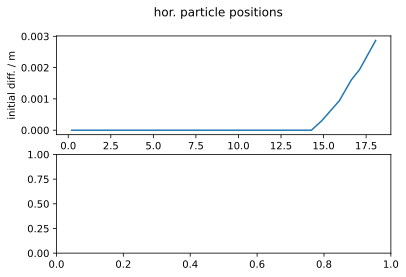

In [30]:
refParticle = torch.zeros((1,2), dtype=dtype)

figTraj, axTraj = plt.subplots(2,1)

compareTrajectories(perturbedModel, model, refParticle, axTraj[0])

figTraj.suptitle("hor. particle positions")

axTraj[0].set_ylabel("initial diff. / m")

plot kick strength diff

In [31]:
def compareKickStrengths(model1, model2, ax):
    model1Kicks, model2Kicks = list(), list()
    
    for m in model1.maps:
        if m.w1.bias is not None:
            model1Kicks.append(m.w1.bias[1].item())
        else:
            model1Kicks.append(0)
    
    for m in model2.maps:
        if m.w1.bias is not None:
            model2Kicks.append(m.w1.bias[1].item())
        else:
            model2Kicks.append(0)
            
    model1Kicks, model2Kicks = np.array(model1Kicks), np.array(model2Kicks)
    
    ax.plot(model1.lattice.positions, model1Kicks - model2Kicks)
    return

Text(0, 0.5, 'before training')

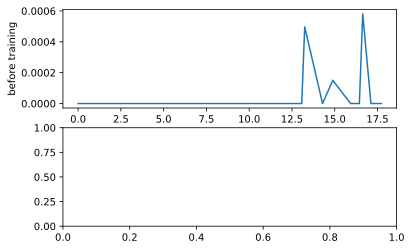

In [32]:
figKick, axKick = plt.subplots(2, 1)

compareKickStrengths(perturbedModel, model, axKick[0])

axKick[0].set_ylabel("before training")

training setup

In [33]:
outputAtBPM = True
xRef = torch.zeros((1,2), dtype=dtype)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, )

refLabel = perturbedModel(xRef, outputAtBPM=outputAtBPM)

fit model to accelerator

In [34]:
# train loop
print("training model")
for epoch in range(300):
    optimizer.zero_grad()

    out = model(xRef, outputAtBPM=outputAtBPM)
    loss = criterion(refLabel, out)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-10)
    optimizer.step()

    if epoch % 10 == 9:
        print("loss: {}".format(loss.item()))

training model
loss: 2.8298723009356763e-06
loss: 2.154288267774973e-06
loss: 1.6134403040268808e-06
loss: 1.2068851447111228e-06
loss: 9.336032462670119e-07
loss: 7.901993512859917e-07
loss: 7.49836033264728e-07
loss: 7.144262781366706e-07
loss: 6.725961156917037e-07
loss: 6.304978796833893e-07
loss: 5.878484898858005e-07
loss: 5.460070724438992e-07
loss: 5.05389948557422e-07
loss: 4.661933985516953e-07
loss: 4.2853235981965554e-07
loss: 3.924344014194503e-07
loss: 3.579183385227225e-07
loss: 3.2498974178452045e-07
loss: 2.9365014597715344e-07
loss: 2.639008016558364e-07
loss: 2.357419646159542e-07
loss: 2.0917320853186538e-07
loss: 1.8419471814468125e-07
loss: 1.6080633713499992e-07
loss: 1.3900793760512897e-07
loss: 1.1879932770852974e-07
loss: 1.0018046481263809e-07
loss: 8.315115707091536e-08
loss: 6.77113121128059e-08
loss: 5.3860738091771054e-08


(1, 31)


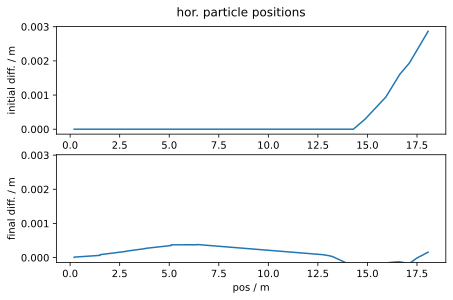

In [35]:
compareTrajectories(perturbedModel, model, refParticle, axTraj[1])

axTraj[1].set_xlabel("pos / m")
axTraj[1].set_ylabel("final diff. / m")

axTraj[1].set_ylim(axTraj[0].get_ylim())

figTraj.tight_layout()
display(figTraj)

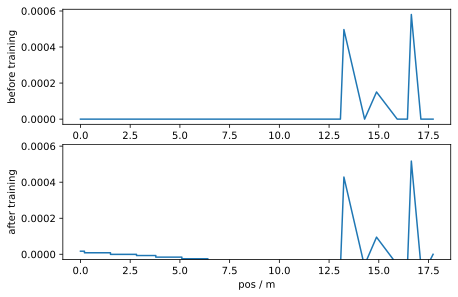

In [36]:
compareKickStrengths(perturbedModel, model, axKick[1])

axKick[1].set_ylim(axKick[0].get_ylim())

axKick[1].set_ylabel("after training")
axKick[1].set_xlabel("pos / m")

figKick.tight_layout()
display(figKick)

"""
************
correct orbits 
************
"""

locate correctors

In [37]:
modelNoCorrectors = copy.deepcopy(model)

correctors = list()
for m in model.maps:
    if type(m.element) is elements.Hcor:
        # add bias
        m.w1.bias = nn.Parameter(torch.zeros(dim, dtype=dtype))
        correctors.append(m)

if not correctors:
    print("no correctors present")
    exit()
else:
    print("found {} correctors".format(len(correctors)))

found 2 correctors


In [38]:
def applyCorrectorSettings(settings: np.array):
    # update correctors
    for corrector, kick in zip(correctors, settings):
        corrector.w1.bias[1] = kick

    # observe trajectory
    out = model(xRef, outputAtBPM=outputAtBPM)

    # max orbit deviation
    maxDev = torch.abs(out)[0].max()  # restrict to x-coord
    return maxDev.item()

minimize orbit deviation

In [39]:
print("optimizing corrector settings")
optimRes = scipy.optimize.minimize(applyCorrectorSettings, np.zeros(len(correctors)), tol=1e-6, method="Nelder-Mead",
                                   options={"maxiter": 200, "disp": True, 'fatol': 1e-6, 'xatol': 1e-6})
print(optimRes)

optimizing corrector settings
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 40
         Function evaluations: 76
 final_simplex: (array([[ 0.00195158, -0.00273113],
       [ 0.00195128, -0.00273062],
       [ 0.0019519 , -0.00273174]]), array([1.44670339e-05, 1.44825044e-05, 1.44861133e-05]))
           fun: 1.4467033906839788e-05
       message: 'Optimization terminated successfully.'
          nfev: 76
           nit: 40
        status: 0
       success: True
             x: array([ 0.00195158, -0.00273113])


In [40]:
for m in model.maps:
    if type(m.element) is elements.Quadrupole:
        print("----")
        print(m.w1.weight.grad)
        print(m.w1.bias.grad)

----
None
tensor([-5.7110e-12, -2.6162e-11])
----
None
tensor([ 5.0504e-12, -2.2406e-11])
----
None
tensor([-2.9244e-12, -2.6508e-11])


show trajectory of reference particle

Text(0.5, 0, 'pos / m')

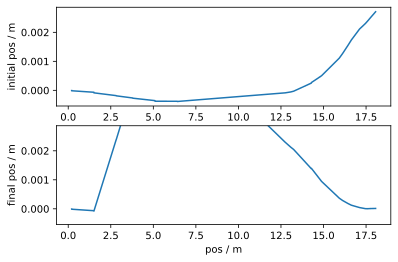

In [41]:
fig, ax = plt.subplots(2,1)

plotTrajectoriesRefParticle(modelNoCorrectors, ax[0])
plotTrajectoriesRefParticle(model, ax[1])

ax[1].set_ylim(ax[0].get_ylim())

ax[0].set_ylabel("initial pos / m")
ax[1].set_ylabel("final pos / m")
ax[1].set_xlabel("pos / m")

apply corrector settings to accelerator

In [42]:
newAccelerator = copy.deepcopy(perturbedModel)

correctors = list()
for m in newAccelerator.maps:
    if type(m.element) is elements.Hcor:
        # add bias
        m.w1.bias = nn.Parameter(torch.zeros(dim, dtype=dtype))
        correctors.append(m)

if not correctors:
    print("no correctors present")
    exit()
else:
    print("found {} correctors".format(len(correctors)))

found 2 correctors


In [43]:
settings = optimRes.x
for corrector, kick in zip(correctors, settings):
        corrector.w1.bias[1] = kick

Text(0, 0.5, 'pos / m')

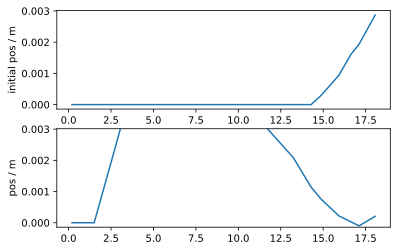

In [44]:
figCorEffect, axCorEffect = plt.subplots(2,1)

plotTrajectoriesRefParticle(perturbedModel, axCorEffect[0])
plotTrajectoriesRefParticle(newAccelerator, axCorEffect[1])

axCorEffect[1].set_ylim(axCorEffect[0].get_ylim())

axCorEffect[0].set_ylabel("initial pos / m")
axCorEffect[1].set_ylabel("final pos / m")
axCorEffect[1].set_ylabel("pos / m")